In [1]:
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)

2.6.2
2.6.0


In [2]:
from keras.layers import Input, Dense,Conv2D, TimeDistributed, Layer, AveragePooling2D, Reshape
from keras.models import Model
import keras.backend as K
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import time

import PIL.Image
%matplotlib inline
import matplotlib.pyplot as plt

In [7]:
bound_pres_large = 400  # north boundary constant pressure
bound_pres_small = 200  # south boundary constant pressure
start_V_cycle_num = 1   # which V cycle to start for training
total_V_cycle_num = 60   # total V cycle number
compl_levels_singleV = [64, 32, 16, 8, 4]   # levels in a complete V cycle
# V cycle levels for different V cycles
multiV_levels = [[8, 4] for i in range(11)] + [[8], [8]] + \
                [[16, 8, 4] for i in range(11)] + [[16], [16]] + \
                [[32, 16, 8, 4] for i in range(11)] + [[32], [32]] + \
                [[64, 32, 16, 8, 4] for i in range(11)] + [[64], [64]] + \
                [[64] for i in range(total_V_cycle_num - 52)]

compl_train_epochs_singleV = [100, 100, 100, 100, 100]   # training epochs for each level in each V cycle
model_save_dir = '/scratch/users/suihong/MutiGrid_2D/TrainedModels/2D_SingleTime/'
batch_size = 256
learning_rate = 1e-4

In [9]:
logpath = model_save_dir + 'log.txt'
def write_to_log(logfilename, dataline):
    with open(logfilename, 'a') as f:
        f.write('%s\n' % dataline)

write_to_log(logpath, tf.__version__)
write_to_log(logpath, keras.__version__)

### 1. Prepare training permeability maps

#### 1.1 Load channel facies models

In [12]:
Filepath = '/scratch/users/suihong/FlowSimulation/Datasets/SynthesizedChannelsLabels/2D_AllPro_Gslib_fromPetrel(version4)' 

In [13]:
allele=[]  
# stores all facies code values of the file. includes 64x64 lists, and each list includes code values of all realizations at each pixel.

with open (Filepath) as fl:
    for line in fl:
        eles = line.strip().split(' ')
       
        if len(eles)>=5:    # filter the lines with property name "Facies unit1 scale1"        
            allele.append(eles)
            
rlz_no = len(allele[0]) # number of realizations


In [14]:
partimgs = np.array(allele, dtype = float).reshape((64, 64, rlz_no)).astype(int)
partimgs = np.where(partimgs == 1, 4, partimgs)/2 * 127.5 # originally, 1 for channel sand facies, and 2 for channel bank; here exchange their codes.
allimgs = np.concatenate((partimgs, partimgs[::-1,:,:]),2)  # partimgs[::-1,:,:] to reverse partimgs vertically: original partimgs 
allimgs = np.transpose(allimgs, (2, 0, 1))  # transpose into (?, 64, 64) dimension
allimgs = allimgs.reshape(-1, 1, 64, 64)

In [15]:
print(allimgs.shape)

(35640, 1, 64, 64)


In [16]:
# randomize the order of images
randseq=np.random.RandomState(232).permutation(allimgs.shape[0])
allimgs = allimgs[randseq]/125.5-1

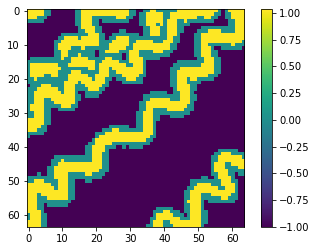

In [17]:
kk = 4805

plt.imshow(allimgs[kk,0])
plt.colorbar()

##### 1.2 Generate permeability maps from the loaded facies models

###### (1) original 64x64 permeability maps

In [18]:
np.random.seed(0)

facies_models_num = allimgs.shape[0]

perm_channel_center = np.random.uniform(1000,4000,facies_models_num)
perm_channel_bank = perm_channel_center * np.random.uniform(0.6,0.85,facies_models_num)
perm_mud = np.random.uniform(5,40,facies_models_num)

for i in range(facies_models_num):
    allimgs[i:i+1] = np.where(allimgs[i:i+1]>=0.75, perm_channel_center[i], allimgs[i:i+1])
    allimgs[i:i+1] = np.where((allimgs[i:i+1]>=-0.75) & (allimgs[i:i+1]<=0.75), perm_channel_bank[i], allimgs[i:i+1])
    allimgs[i:i+1] = np.where(allimgs[i:i+1]<=-0.75, perm_mud[i], allimgs[i:i+1])

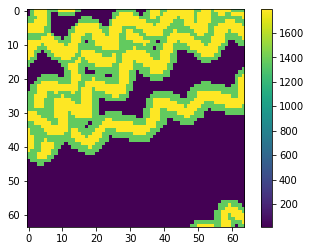

In [19]:
plt.imshow(allimgs[30,0,:,:])
plt.colorbar()

In [20]:
perm_no = 35000

perm_train_64 = allimgs[:perm_no]
print(perm_train_64.shape)

(35000, 1, 64, 64)


###### (2) obtain 32x32 to 8x8 permeability maps by downsampling the original 64x64 perm maps

In [ ]:
from scipy import stats
perm_train_32 = np.zeros([perm_no, 1, 32, 32], dtype=np.float32)
perm_train_16 = np.zeros([perm_no, 1, 16, 16], dtype=np.float32)
perm_train_8 = np.zeros([perm_no, 1, 8, 8], dtype=np.float32)
perm_train_4 = np.zeros([perm_no, 1, 4, 4], dtype=np.float32)

def HighestFrequencyDesampling(real_img):  # dsample real_img by 2
    # used to produce low-D with most frequent facies code
    real_img_t = np.expand_dims(real_img, axis = 3)
    real_img_t_c = np.concatenate((real_img_t[:, 0::2, 0::2], real_img_t[:, 0::2, 1::2], real_img_t[:, 1::2, 0::2], real_img_t[:, 1::2, 1::2]), axis = 3)                
    mode, _ = stats.mode(real_img_t_c, axis = 3)
    real_img = np.squeeze(mode, axis = 3)
    return real_img

def AveragingDesampling(real_img): #Downsample real_img by 2
    # used to produce low-D with averaging method
    real_img = (real_img[:, 0::2, 0::2] + real_img[:, 0::2, 1::2] + real_img[:, 1::2, 0::2] + real_img[:, 1::2, 1::2]) * 0.25
    return real_img    

for idx in range(0, perm_train_64.shape[0]):
    # 32x32 and 16x16 are downsampled using highest frequency method, while 8x8 and 4x4 are obtained using average metho.
    real_img = perm_train_64[idx].astype(np.float32)
    real_img = HighestFrequencyDesampling(real_img) # downsampling into 32x32
    perm_train_32[idx] = real_img
    real_img = HighestFrequencyDesampling(real_img) # downsampling into 16x16
    perm_train_16[idx] = real_img
    
    real_img = AveragingDesampling(real_img) 
    perm_train_8[idx] = real_img    
    real_img = AveragingDesampling(real_img) 
    perm_train_4[idx] = real_img    


In [75]:
perm_train_64 = perm_train_64.astype('float32')
perm_train_32 = perm_train_32.astype('float32')
perm_train_16 = perm_train_16.astype('float32')
perm_train_8  = perm_train_8.astype('float32')
perm_train_4  = perm_train_4.astype('float32')

##### Since Downsampling process takes relatively long time, after downsampling, we save these downsampled data for future use

In [87]:
save_name_64 = '/scratch/users/suihong/MutiGrid_2D/TrainingPermMaps/train_perm_64_orig.txt'
np.savetxt(save_name_64, perm_train_64.reshape(-1, 64), fmt='%i', delimiter=' ', newline='\n')

save_name_32 = '/scratch/users/suihong/MutiGrid_2D/TrainingPermMaps/train_perm_32_highestfreq.txt'
np.savetxt(save_name_32, perm_train_32.reshape(-1, 32), fmt='%i', delimiter=' ', newline='\n')

save_name_16 = '/scratch/users/suihong/MutiGrid_2D/TrainingPermMaps/train_perm_16_highestfreq.txt'
np.savetxt(save_name_16, perm_train_16.reshape(-1, 16), fmt='%i', delimiter=' ', newline='\n')

save_name_8 = '/scratch/users/suihong/MutiGrid_2D/TrainingPermMaps/train_perm_8_av.txt'
np.savetxt(save_name_8, perm_train_8.reshape(-1, 8), fmt='%i', delimiter=' ', newline='\n')

save_name_4 = '/scratch/users/suihong/MutiGrid_2D/TrainingPermMaps/train_perm_4_av.txt'
np.savetxt(save_name_4, perm_train_4.reshape(-1, 4), fmt='%i', delimiter=' ', newline='\n')


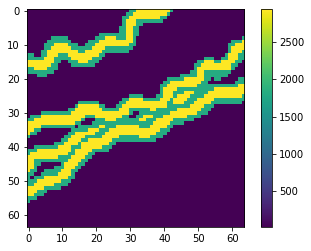

In [78]:
plt.imshow(perm_train_64[5, 0])
plt.colorbar()

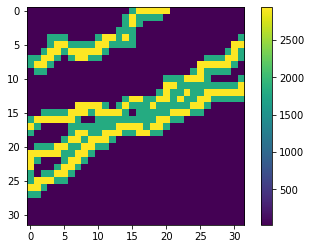

In [79]:
plt.imshow(perm_train_32[5, 0])
plt.colorbar()

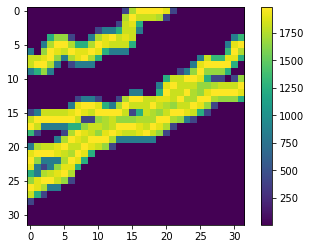

In [80]:
plt.imshow(perm_train_32_highfreq[5, 0])
plt.colorbar()

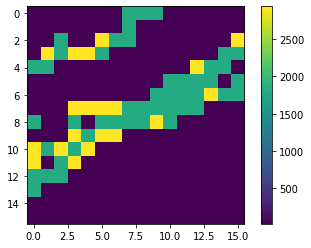

In [81]:
plt.imshow(perm_train_16[5, 0])
plt.colorbar()

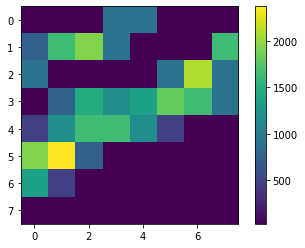

In [82]:
plt.imshow(perm_train_8[5, 0])
plt.colorbar()

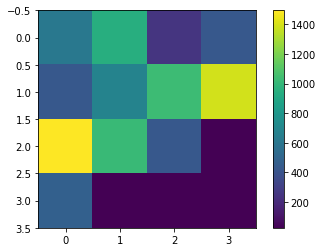

In [83]:
plt.imshow(perm_train_4[5, 0])
plt.colorbar()

##### 1.3 Load previously saved permeability maps (optional)

In [22]:
def import_perm(perm_dir, perm_num):
    saved_perm_path = perm_dir +'permmap_'+str(perm_num)
    with open(saved_perm_path, 'r') as f:
        alist = []
        for line in f:
            if line.startswith('PERMI') or line.startswith('/'):
                continue
            else:
                s = line.strip()
                s = np.array(s.split()).astype(np.float32)
                alist= np.concatenate((alist, s))    
        permarray = alist
        
    return permarray

In [ ]:
test_perm_dir_64 = '/scratch/users/suihong/MutiGrid_2D/TrainingPermMaps/train_perm_64_orig.txt'
perm_train_64 = np.loadtxt(test_perm_dir_64, dtype='int', delimiter= ' ').reshape(-1, 1, 64, 64)
print(perm_train_64.shape)

test_perm_dir_32 = '/scratch/users/suihong/MutiGrid_2D/TrainingPermMaps/train_perm_32_highestfreq.txt'
perm_train_32 = np.loadtxt(test_perm_dir_32, dtype='int', delimiter= ' ').reshape(-1, 1, 32, 32)
print(perm_train_32.shape)

test_perm_dir_16 = '/scratch/users/suihong/MutiGrid_2D/TrainingPermMaps/train_perm_16_highestfreq.txt'
perm_train_16 = np.loadtxt(test_perm_dir_16, dtype='int', delimiter= ' ').reshape(-1, 1, 16, 16)
print(perm_train_16.shape)

test_perm_dir_8 = '/scratch/users/suihong/MutiGrid_2D/TrainingPermMaps/train_perm_8_av.txt'
perm_train_8 = np.loadtxt(test_perm_dir_8, dtype='int', delimiter= ' ').reshape(-1, 1, 8, 8)
print(perm_train_8.shape)

test_perm_dir_4 = '/scratch/users/suihong/MutiGrid_2D/TrainingPermMaps/train_perm_4_av.txt'
perm_train_4 = np.loadtxt(test_perm_dir_4, dtype='int', delimiter= ' ').reshape(-1, 1, 4, 4)
print(perm_train_4.shape)

In [81]:
perm_train_64 = perm_train_64.astype('float32')
perm_train_32 = perm_train_32.astype('float32')
perm_train_16 = perm_train_16.astype('float32')
perm_train_8  = perm_train_8.astype('float32')
perm_train_4  = perm_train_4.astype('float32')

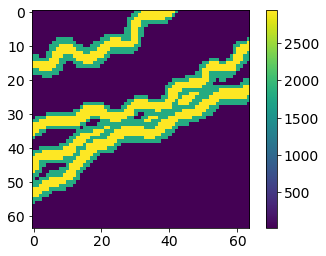

In [82]:
plt.imshow(perm_train_64[5, 0])
plt.colorbar()

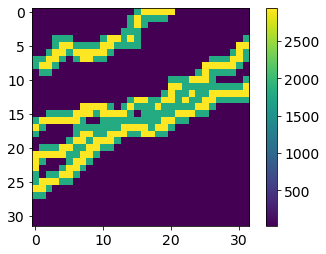

In [83]:
plt.imshow(perm_train_32[5, 0])
plt.colorbar()

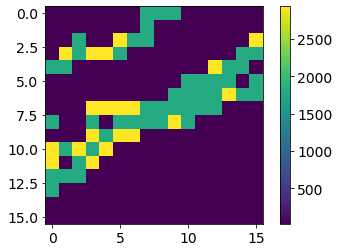

In [84]:
plt.imshow(perm_train_16[5, 0])
plt.colorbar()

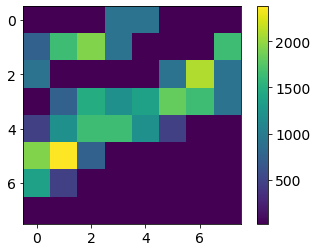

In [85]:
plt.imshow(perm_train_8[5, 0])
plt.colorbar()

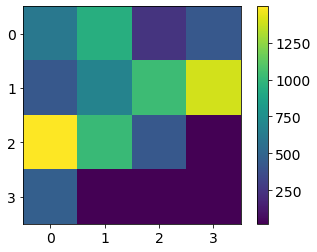

In [86]:
plt.imshow(perm_train_4[5, 0])
plt.colorbar()

### 2 Train multi-grid neural operator

#### (1) Define architectures and losses

In [11]:
import tensorflow as tf

In [12]:
class RangeConversion(Layer):
    def __init__(self, range_in, range_out): # input and output range 
        [self.range_in_sm, self.range_in_lg] = range_in
        [self.range_out_sm, self.range_out_lg] = range_out            
        super(RangeConversion, self).__init__()
    def call(self, parameters):
        parameters_out = (parameters - self.range_in_sm) / (self.range_in_lg - self.range_in_sm) * \
                         (self.range_out_lg - self.range_out_sm) + self.range_out_sm
        return parameters_out

def CNN_block(x, block_lod, pixel):
    block_pixel = 2**block_lod
    with tf.compat.v1.variable_scope('CNN_%d' % block_pixel):
        layer1 = Conv2D(block_pixel/2, kernel_size = 3, padding="same", data_format = 'channels_first', activation='softplus', \
                        kernel_initializer=initializer, bias_initializer= initializer)(x) 
        return layer1                

def DownSamp_block(x, block_lod, pixel):
    block_pixel = 2**block_lod
    with tf.compat.v1.variable_scope('DownSamp_%d' % block_pixel):
        layer1 = AveragePooling2D(pool_size=(2, 2), strides = (2, 2), padding='valid', data_format= 'channels_first')(x)    
        return layer1       

def UpSamp_block(x, block_lod, pixel):
    block_pixel = 2**block_lod
    with tf.compat.v1.variable_scope('UpSamp_%d' % block_pixel):
        s = x.shape
        x = tf.reshape(x, [-1, s[1], s[2], 1, s[3], 1])
        x = tf.tile(x, [1, 1, 1, 2, 1, 2])
        x = tf.reshape(x, [-1, s[1], s[2] * 2, s[3] * 2])    
        return x    
    
def Dense_block(x, block_lod, pixel):
    block_pixel = 2**block_lod
    with tf.compat.v1.variable_scope('Dense_%d' % block_pixel):
        neur_num = x.shape[1] * x.shape[2] * x.shape[3]
        layer1 = Reshape((neur_num, ))(x)
        layer2 = Dense(neur_num, activation='softplus', kernel_initializer=initializer, bias_initializer= initializer)(layer1) 
        layer3 = Reshape((x.shape[1], x.shape[2], x.shape[3]))(layer2)
        return layer3      

def Conc_block(x1, x2, block_lod):
    block_pixel = 2**block_lod
    with tf.compat.v1.variable_scope('Conct_%d' % block_pixel):  
        layer1 = tf.concat([x1, x2], axis = 1)
    return layer1
        
def gaussian_kernel(size: int, mean: float, std: float,):
    """Makes 2D gaussian Kernel for convolution."""
    d = tf.compat.v1.distributions.Normal(mean, std)
    vals = d.prob(tf.range(start = -size, limit = size + 1, dtype = tf.float32))
    gauss_kernel = tf.einsum('i,j->ij', vals, vals)
    return gauss_kernel / tf.reduce_sum(gauss_kernel)
                    
def GS_block(x, pixel):
    with tf.compat.v1.variable_scope('GS_%d' % pixel):
        sm_kernel = gaussian_kernel(int(pixel/20), 0., pixel/25)[:, :, tf.newaxis, tf.newaxis]  
        layer1 = tf.nn.conv2d(x, sm_kernel, strides=[1, 1,1,1], padding='SAME', data_format='NCHW') 
        return layer1
    
initializer = tf.keras.initializers.GlorotNormal()    
def create_CNN_model(type = 'original', pixel = 64, initializer = tf.keras.initializers.GlorotNormal()):
    # type: 'original' for original model producing pressure map from perm map; 
    #       'error' for error model producing pressure error map from (perm map + residual map) 
    # pixel: pixel number of input and output maps, a value from (64, 32, 16, 8)

    with tf.compat.v1.variable_scope('Preproc'):
        if type == 'original':
            t = Input(shape = (1, pixel, pixel), name = 'input')
            x = RangeConversion([0, 4000], [-1, 1])(t)
        elif type == 'error':
            t = Input(shape = (2, pixel, pixel), name = 'input')  # channel 0: perm map; channel 1: residual map
            x = tf.concat([RangeConversion([0, 4000], [-1, 1])(t[:, 0:1]), t[:, 1:2]], axis = 1, name = 'input_rangeconversion')
     
    with tf.compat.v1.variable_scope('Encoder'):
        res_layers = []
        lod = int(np.log2(pixel))         
        for i in range(lod, 1, -1):  # i from 6 to 2
            if i >= 3:
                x = CNN_block(x, i, pixel)
                res_layers.append(x)
                x = DownSamp_block(x, i, pixel)
            else:      
                x = Dense_block(x, i, pixel)
               
    with tf.compat.v1.variable_scope('Decoder'):
        for i in range(3, lod + 1):
            x = UpSamp_block(x, i, pixel)
            x = Conc_block(x, res_layers[2 - i], i)
            x = CNN_block(x, i, pixel)
           
        output = Conv2D(1, kernel_size = 3, padding="same", data_format = 'channels_first', activation='linear', \
                        kernel_initializer=initializer, bias_initializer= initializer)(x) 
        # Smoothing the output with Gaussian kernel
        if type == 'original':
            output = GS_block(output, pixel)
 
    return Model(t, output)


In [13]:
# calculate residual matrix from pde using finite difference method

def residual_matrix(network_inputs, network_outputs, boundary_strenghten = False, boundary_w = 10):  # network_inputs of shape (N, 1(or 2), 64, 64)   network_outputs of shape (N, 1, 64, 64)    
    type = 'original' if network_inputs.shape[1] == 1 else 'error'
    pixel = network_inputs.shape[-1]
    
    dt = 30
    dx = 50.* (64 / pixel)
    dy = 50.* (64 / pixel)
    miu = 2
    Ct = 1.8*10**(-2)
    unit_trans_para = 8.52702    
   
    if type == 'original':
        bound_sta_value = bound_pres_large
        bound_end_value = bound_pres_small
    elif type == 'error':
        bound_sta_value = 0
        bound_end_value = 0        
        
    #network_outputs = tf.expand_dims(network_outputs, axis = 2)    
    bound_sta = tf.zeros(shape = (tf.shape(network_outputs)[0], 1, 1, pixel))+bound_sta_value     # shape of (N, 1, 1, 64)
    bound_end = tf.zeros(shape = (tf.shape(network_outputs)[0], 1, 1, pixel))+bound_end_value     # shape of (N, 1, 1, 64)
    init_map = tf.zeros(shape = (tf.shape(network_outputs)[0], 1, pixel, pixel+2))+bound_end_value  # shape of (N, 1, 64, 66)
 
    network_outputs = tf.concat([bound_sta, network_outputs[:,:,1:-1], bound_end], axis = 2)  # shape of (N, 1, 64, 64) 
    network_outputs = tf.concat([network_outputs[:, :, :, :1], network_outputs, network_outputs[:, :, :, -1:]], axis = 3) # shape of (N, 1, 64, 66)  
    network_outputs = tf.concat([init_map, network_outputs], axis = 1)  # shape of (N, 2, 64, 66)
    
    perm = network_inputs[:, 0:1]    # shape of (N, 1, 64, 64)
    perm = tf.concat([perm[:, :, :, :1], perm, perm[:, :, :, -1:]], axis = 3) # shape of (N, 1, 64, 66)  
    perm_east = (2 * perm[:, :, 1:-1, 1:-1] * perm[:, :, 1:-1, 2: ]) / (perm[:, :, 1:-1, 1:-1] + perm[:, :, 1:-1, 2: ])  # shape of (N, 1, 62, 64)
    perm_west = (2 * perm[:, :, 1:-1, 1:-1] * perm[:, :, 1:-1, :-2]) / (perm[:, :, 1:-1, 1:-1] + perm[:, :, 1:-1, :-2])# shape of (N, 1, 62, 64)
    perm_north = (2 * perm[:, :, 1:-1, 1:-1] * perm[:, :, :-2, 1:-1]) / (perm[:, :, 1:-1, 1:-1] + perm[:, :, :-2, 1:-1])# shape of (N, 1, 62, 64)
    perm_south = (2 * perm[:, :, 1:-1, 1:-1] * perm[:, :, 2: , 1:-1]) / (perm[:, :, 1:-1, 1:-1] + perm[:, :, 2: , 1:-1])# shape of (N, 1, 62, 64)

    output_deri_x_east = (network_outputs[:, 1:, 1:-1, 2:  ] - network_outputs[:, 1:, 1:-1, 1:-1]) / dx  # shape of (N, 1, 62, 64)
    output_deri_x_west = (network_outputs[:, 1:, 1:-1, 1:-1] - network_outputs[:, 1:, 1:-1, :-2]) / dx  # shape of (N, 1, 62, 64)
    output_deri_y_north = (network_outputs[:, 1:, 1:-1, 1:-1] - network_outputs[:, 1:, :-2 , 1:-1]) / dy  # shape of (N, 1, 62, 64)
    output_deri_y_south = (network_outputs[:, 1:, 2:  , 1:-1] - network_outputs[:, 1:, 1:-1, 1:-1]) / dy  # shape of (N, 1, 62, 64)    

    network_deri_t = (network_outputs[:, 1:, 1:-1, 1:-1] - network_outputs[:, 0:1, 1:-1, 1:-1]) / dt  # shape of (N, 1, 62, 64)
    
    left_term = unit_trans_para * ((perm_east * output_deri_x_east - perm_west * output_deri_x_west) / dx + \
                                   (perm_south * output_deri_y_south - perm_north * output_deri_y_north) / dy)                                  
    right_term = miu * Ct * network_deri_t  
    pde_matrix = left_term - right_term   # shape of (N, 1, 62, 64)
    if boundary_strenghten:
        weight_matrix = tf.concat([boundary_w * tf.ones([tf.shape(pde_matrix)[0],tf.shape(pde_matrix)[1], 1, tf.shape(pde_matrix)[-1]]), \
                          tf.ones(tf.shape(pde_matrix))[:,:,1:-1],\
                          boundary_w * tf.ones([tf.shape(pde_matrix)[0], tf.shape(pde_matrix)[1], 1, tf.shape(pde_matrix)[-1]])], axis = 2)
        pde_matrix = pde_matrix * weight_matrix   # shape of (N, 1, 62, 64)
    
    if type == 'error':
        res = network_inputs[:, 1:2]  # shape of (N, 1, 64, 64)
        pde_matrix = pde_matrix - res[:, :, 1:-1]     # shape of (N, 1, 62, 64)
    
    return pde_matrix  # shape of (N, 1, 62, 64)

import tensorflow_probability as tfp
def pde_loss(network_inputs, network_outputs):  # network_inputs of shape (N, 1(or 2), 64, 64)   network_outputs of shape (N, 1, 64, 64)  
    pde_matrix = residual_matrix(network_inputs, network_outputs)   # shape of (N, 1, 62, 64)
    pde_matrix_sq = pde_matrix**2
    loss_1 = K.sqrt(K.mean(pde_matrix_sq))  # mean square root loss for each cell: sqrt((x1^2 + x2^2 + ... + xn^2)/n);  

    quantile = tfp.stats.percentile(pde_matrix_sq, q = 50, interpolation = 'linear')
    pde_matrix_sq_lg = tf.where(pde_matrix_sq < quantile, 0., pde_matrix_sq)
    loss_2 = K.sqrt(K.mean(pde_matrix_sq_lg))
        
    loss = 0.3 * loss_1 + 0.7 * loss_2
          
    return loss  # shape of (N, )

In [14]:
def residual_downscale(cur_residual):  # shape of cur_residual (N, 1, 64, 64) which is supplemented by 0s from (N, 1, 62, 62)
    new_res = (cur_residual[:, :, :-1:2, :-1:2] + cur_residual[:, :, :-1:2, 1::2] + \
               cur_residual[:, :, 1::2 , :-1:2] + cur_residual[:, :, 1::2 , 1::2]) / 4
    return new_res  # shape of cur_residual (N, 1, 32, 32)

def upscale(cur_maps):
    map_num = cur_maps.shape[0]
    map_ch = cur_maps.shape[1]
    cur_pixel = cur_maps.shape[-1]
    up_maps = np.zeros((map_num, map_ch, cur_pixel * 2-1, cur_pixel * 2-1))
    up_maps[:, :, ::2, ::2] = cur_maps 
    up_maps[:, :, 1::2] = (up_maps[:, :, 0:-1:2] + up_maps[:, :, 2::2]) / 2
    up_maps[:, :, :, 1::2] = (up_maps[:, :, :, 0:-1:2] + up_maps[:, :, :, 2::2]) / 2
    up_maps = np.insert(up_maps, cur_pixel, 0, axis = 2)
    up_maps[:, :, cur_pixel - 1] = (up_maps[:, :, cur_pixel + 1] - up_maps[:, :, cur_pixel - 2]) / 3 + up_maps[:, :, cur_pixel - 2]
    up_maps[:, :, cur_pixel] = (up_maps[:, :, cur_pixel + 1] - up_maps[:, :, cur_pixel - 2]) / 3 * 2 + up_maps[:, :, cur_pixel - 2]
    up_maps = np.insert(up_maps, cur_pixel, 0, axis = 3)
    up_maps[:, :, :, cur_pixel - 1] = (up_maps[:, :, :, cur_pixel + 1] - up_maps[:, :, :, cur_pixel - 2]) / 3 + up_maps[:, :, :, cur_pixel - 2]
    up_maps[:, :, :, cur_pixel] = (up_maps[:, :, :, cur_pixel + 1] - up_maps[:, :, :, cur_pixel - 2]) / 3 * 2 + up_maps[:, :, :, cur_pixel - 2]    
    return up_maps

def level_NN_train(level, NN_type, perm, residual, train_epoch, batch_size, learning_rate = 1e-4):
    # level: resolution level: 64, 32, 16, 8
    # residual: 2D residual map with the same resolution as the current lvel or twice of the current level value, e.g., [N, 1, 64, 64] at level = 32
    # perm: 2D permeability maps with shape of [N, 1, 64, 64] and type of 'float32' 
    # NN_type: network type, 'original' or 'error'
    
    train_num = residual.shape[0]
    residual_resolution = residual.shape[-1]
        
    CNN_model = create_CNN_model(type = NN_type, pixel = level)
    CNN_model.compile(loss = pde_loss, optimizer = Adam(lr=learning_rate), metrics = [pde_loss])
    
    if NN_type == 'error': 
        if residual_resolution == 2 * level: residual = residual_downscale(residual)
        train_inputs = np.concatenate([perm, residual], axis = 1).astype(np.float32)
    elif NN_type == 'original':
        train_inputs = perm
    
    CNN_model.fit(train_inputs, train_inputs, batch_size = batch_size, epochs = train_epoch, \
                  verbose = 0, validation_data = (train_inputs[:50], train_inputs[:50]))
    
    bou_st = bound_pres_large if NN_type == 'original' else 0    
    bou_ed = bound_pres_small if NN_type == 'original' else 0
    NNoutput = CNN_model.predict(train_inputs)
    NNoutput[:,0, 0 ] = bou_st
    NNoutput[:,0, -1] = bou_ed
    new_residual = np.zeros((train_num, 1, level, level))  # of shape [N, 1, 64, 64]
    new_residual[:, :, 1:-1] = residual_matrix(train_inputs, NNoutput)

    return CNN_model, new_residual

def V_cycle_train(levels, NN_types, perms, train_epochs, batch_size, learning_rate, ini_residual):
    # levels: e.g., [64, 32, 16, 8]
    # NN_types: e.g., ['original', 'error', 'error', 'error']
    # perm maps: e.g., [perm_64, perm_32, perm_16, perm_8], with each perm of shape e.g., [N, 1, 64, 64]
    # ini_residual: initial residual
    
    level_num = len(levels)
    CNN_models = []

    for i in range(level_num):
        level = levels[i]
        print('training for level:' + str(level))
        NN_type = NN_types[i]
        perm = perms[i]
        if i == 0: residual = ini_residual 
        train_epoch = train_epochs[i]
        CNN_model, new_residual = level_NN_train(level, NN_type, perm, residual, train_epoch, batch_size, learning_rate)  
        CNN_models.append(CNN_model)        
        residual = new_residual
     
    return CNN_models


In [15]:
def level_NN_predict(level, NN, NN_type, perm, residual):
    # level: resolution level: 64, 32, 16, 8
    # residual: 2D residual map with the same resolution as the current lvel or twice of the current level value, e.g., [N, 1, 64, 64] at level = 32
    # perm: 2D permeability maps with shape of [N, 1, 64, 64] and type of 'float32' 
    # NN_type: network type, 'original' or 'error'
    
    num = residual.shape[0]
    residual_resolution = residual.shape[-1] 
    
    if NN_type == 'error': 
        if residual_resolution == 2 * level: residual = residual_downscale(residual)
        NN_inputs = np.concatenate([perm, residual], axis = 1).astype(np.float32) 
        bou_st = 0
        bou_end = 0        
    elif NN_type == 'original':
        NN_inputs = perm
        bou_st = bound_pres_large
        bou_end = bound_pres_small        

    NNoutput = NN.predict(NN_inputs)
    NNoutput[:,0, 0] = bou_st
    NNoutput[:,0, -1] = bou_end
    new_residual = np.zeros(perm.shape)
    new_residual[:, :, 1:-1] = residual_matrix(NN_inputs, NNoutput)
    
    return NNoutput, new_residual

       
class NNs_pipeline():
    # NNs: trained neural networks from large to small levels, e.g., [NN_64, NN_32, NN_16, NN_8]
    # NN_types: e.g., ['original', 'error', 'error', 'error']
  
    def __init__(self, levels, NNs, NN_types):
        self.levels = levels
        self.NNs = NNs        
        self.NN_num = len(self.NNs)
        self.NN_types = NN_types

    def mapping(self, perms, ini_residual, ini_pred):
        # perms: e.g., [perm_64, perm_32, perm_16, perm_8], with each perm of shape e.g., [N, 1, 64, 64]
        # ini_residual: initial residual, of shape [N, 1, 64, 64]
        # ini_pred: initial prediction, of shape [N, 1, 64, 64]        
        NN_outputs = []
        for i in range(self.NN_num):
            if i == 0: residual = ini_residual            
            NN_output, new_residual = level_NN_predict(self.levels[i], self.NNs[i], self.NN_types[i], perms[i], residual)
            NN_outputs.append(NN_output)
            residual = new_residual
        if self.NN_types[0] == 'original':
            prediction = np.zeros(NN_outputs[-1].shape)            
            for j in range(self.NN_num - 1, 0, -1):
                prediction = - upscale(NN_outputs[j] + prediction) 
            prediction = NN_outputs[0] + prediction
        if self.NN_types[0] == 'error':
            prediction = np.zeros(NN_outputs[-1].shape)            
            for j in range(self.NN_num - 1, 0, -1):
                prediction = - upscale(NN_outputs[j] + prediction) 
            prediction = ini_pred - (NN_outputs[0] + prediction)
            
        final_residual = np.zeros(perms[0].shape)
        final_residual[:, :, 1:-1] = residual_matrix(perms[0], prediction)       
        return prediction, final_residual      

In [16]:
# Save trained models
def save_models(model_dir, V_cycle, levels, models_save):
    # e.g., V_cycle = 1
    # e.g., levels = [64, 32, 16, 8]
    # e.g., model_dir = '/scratch/users/suihong/MutiGrid_2D/TrainedModels/BoundPres_360_260/'
    # models_save: e.g., [model_64, model_32, ...]    
    model_save_dir = model_dir + 'Vcycle' + str(V_cycle) + '/'
    for i in range(len(levels)):
        level = levels[i]
        model = models_save[i]
        model_save_name = 'CNNmodel_' + str(level)
        model.save(model_save_dir + model_save_name)
        
# Load saved trained models     
def load_models(model_dir, V_cycle, levels):
    # e.g., V_cycle = 1
    # e.g., levels = [64, 32, 16, 8]
    # e.g., model_dir = '/scratch/users/suihong/MutiGrid_2D/TrainedModels/BoundPres_360_260/'  
    model_save_dir = model_dir + 'Vcycle' + str(V_cycle) + '/'
    CNN_models_load = []
    for i in range(len(levels)):
        level = levels[i]
        model_name = 'CNNmodel_' + str(level)
        CNN_models_load.append(tf.keras.models.load_model(model_save_dir + model_name, compile = False))
    return CNN_models_load

In [17]:
def find_index(short_list, long_list):
    index = []
    for i in range(len(short_list)):
        for j in range(len(long_list)):
            if short_list[i] == long_list[j]:
                index.append(j)
                break    
    return(index)

def run_multi_V_cycles(sta_V_cycle, total_V_cycle_num, compl_levels_singleV, multiV_levels, model_save_dir, compl_train_perms_singleV, \
                       compl_train_epochs_singleV,batch_size = 256, learning_rate = 1e-4):
    # sta_V_cycle: which V_cycle to start from; i.e., 1, 2, 3, ...
    # total_V_cycle_num: how many V-cycles to run, e.g., 9
    # compl_levels_singleV: complete levels for single V cycle, e.g., [64, 32, 16, 8, 4]
    # multiV_levels: levels for multiple V cycles, e.g., [[16, 8], [32, 16, 8], [64, 32, 16], ...]
    # prev_residual and prev_pres_pred are residual maps and pressure prediction maps taken as inputs by previous V-cycle;
    # e.g., if sta_V_cycle = 7, then prev_residual and prev_pres_pred are the output of 5's V-cycle.
    
    if start_V_cycle_num == 1:
        level_ind_initV = find_index(multiV_levels[0], compl_levels_singleV)
        prev_residual = np.zeros(compl_train_perms_singleV[level_ind_initV[0]].shape)  # train_perms[0] is perm_train_64 
        prev_pres_pred = np.zeros(compl_train_perms_singleV[level_ind_initV[0]].shape)   
    else:
        pipls_list = build_Vcycle_pipls(start_V_cycle_num - 1, multiV_levels, model_save_dir)
        prev_pres_pred, prev_residual = pred_with_Vcycle_pipls(start_V_cycle_num - 1, pipls_list, compl_levels_singleV, \
                                                               multiV_levels, compl_train_perms_singleV)
    
    for V_cycle in range(sta_V_cycle, total_V_cycle_num + 1):
        levels = multiV_levels[V_cycle - 1]  # e.g., [16, 8]       
        level_index = find_index(levels, compl_levels_singleV)
        train_perms = [compl_train_perms_singleV[i] for i in level_index]
        train_epochs = [compl_train_epochs_singleV[i] for i in level_index]                
        print_term = 'Training for V cycle: ' + str(V_cycle)
        write_to_log(logpath, print_term)
        write_to_log(logpath, levels)
        write_to_log(logpath, train_epochs)
        NN_types = ['original'] + ['error' for i in range(len(levels) - 1)] if V_cycle == 1 else ['error'] + ['error' for i in range(len(levels) - 1)]    
        if (V_cycle > 1) and (levels[0] > multiV_levels[V_cycle - 2][0]): 
            for t in range(int(np.log2(levels[0] / multiV_levels[V_cycle - 2][0]))):
                prev_pres_pred = upscale(prev_pres_pred)
            prev_residual = residual_matrix(train_perms[0], prev_pres_pred, boundary_strenghten = False)  
            prev_residual = np.concatenate((np.zeros((prev_residual.shape[0], prev_residual.shape[1], 1, prev_residual.shape[-1])), \
                                           prev_residual, np.zeros((prev_residual.shape[0], prev_residual.shape[1], 1, prev_residual.shape[-1]))), axis = 2)
        CNN_models_trained = V_cycle_train(levels, NN_types, train_perms, train_epochs, batch_size, learning_rate, prev_residual)
        save_models(model_save_dir, V_cycle, levels, CNN_models_trained)       
        mg_time_ed = time.time()
        print_term = 'Cumulative time used till V cycle ' + str(V_cycle) + ' : ' + str(mg_time_ed - mg_time_st)
        write_to_log(logpath, print_term)     
        prev_pres_pred, prev_residual = NNs_pipeline(levels, CNN_models_trained, NN_types).mapping(train_perms, prev_residual, prev_pres_pred)

In [18]:
def build_Vcycle_pipls(V_cycle_num, multiV_levels, model_save_dir):
    # V_cycle_num: how many V-cycles to rewoke, e.g., 9
    pipls_list = []
    for V_cycle in range(1, V_cycle_num + 1):
        print(V_cycle)
        levels = multiV_levels[V_cycle - 1]
        models = load_models(model_save_dir, V_cycle, levels)
        # build NN pipeline from perm to pressure
        NN_types = ['original'] + ['error' for i in range(len(levels) - 1)] if V_cycle == 1 else ['error'] + ['error' for i in range(len(levels) - 1)]
        Vcycle_pipl = NNs_pipeline(levels, models, NN_types)
        pipls_list.append(Vcycle_pipl)
    return pipls_list

def pred_with_Vcycle_pipls(V_cycles, Vpipls_list, compl_levels_singleV, multiV_levels, compl_train_perms_singleV):
    # V_cycles: how many V-cycles want use for predict
    for V_cycle in range(0, V_cycles):
        levels = multiV_levels[V_cycle]
        level_ind_initV = find_index(levels, compl_levels_singleV)
        perms = [compl_train_perms_singleV[i] for i in level_ind_initV]  
        if V_cycle == 0:
            prev_residual = np.zeros(compl_train_perms_singleV[level_ind_initV[0]].shape)  # train_perms[0] is perm_train_64 
            prev_pres_pred = np.zeros(compl_train_perms_singleV[level_ind_initV[0]].shape)
        elif levels[0] > multiV_levels[V_cycle - 1][0]: 
            for t in range(int(np.log2(levels[0] / multiV_levels[V_cycle - 1][0]))):
                prev_pres_pred = upscale(prev_pres_pred)
            prev_residual = residual_matrix(perms[0], prev_pres_pred, boundary_strenghten = False) 
            prev_residual = np.concatenate((np.zeros((prev_residual.shape[0], prev_residual.shape[1], 1, prev_residual.shape[-1])), \
                                           prev_residual, np.zeros((prev_residual.shape[0], prev_residual.shape[1], 1, prev_residual.shape[-1]))), axis = 2)
        V_cycle_pipl = Vpipls_list[V_cycle]
        prev_pres_pred, prev_residual = V_cycle_pipl.mapping(perms, prev_residual, prev_pres_pred)     
    return prev_pres_pred, prev_residual

#### Run multiple V cycles

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
bound_pres_large = 400
bound_pres_small = 200
start_V_cycle_num = 1
total_V_cycle_num = 60
compl_levels_singleV = [64, 32, 16, 8, 4]
multiV_levels = [[8, 4] for i in range(11)] + [[8], [8]] + \
                [[16, 8, 4] for i in range(11)] + [[16], [16]] + \
                [[32, 16, 8, 4] for i in range(11)] + [[32], [32]] + \
                [[64, 32, 16, 8, 4] for i in range(11)] + [[64], [64]] + \
                [[64] for i in range(total_V_cycle_num - 52)]

compl_train_epochs_singleV = [80, 80, 80, 80, 80]
model_save_dir = '/scratch/users/suihong/MutiGrid_2D/TrainedModels/2D_SingleTime/'
batch_size = 256
learning_rate = 1e-4

logpath = model_save_dir + 'log.txt'
write_to_log(logpath, tf.__version__)
write_to_log(logpath, keras.__version__)

In [ ]:
# Run multiple V cycles
import time
mg_time_st = time.time()
write_to_log(logpath, "Num GPUs Available: " + str(len(tf.config.list_physical_devices('GPU'))))
# train with multiple parallel GPUs
mirrored_strategy = tf.distribute.MirroredStrategy()
compl_train_perms_singleV = [perm_train_64, perm_train_32, perm_train_16, perm_train_8, perm_train_4]

with mirrored_strategy.scope():
    run_multi_V_cycles(start_V_cycle_num, total_V_cycle_num, compl_levels_singleV, multiV_levels, model_save_dir, compl_train_perms_singleV, \
                       compl_train_epochs_singleV, batch_size = batch_size, learning_rate = learning_rate)

### 3. Evaluation of trained operator

#### 3.1 Load 640 test permeability-pressure maps (cal. from Eclipse) for evaluation of trained operators

In [24]:
def import_perm(perm_dir, perm_num):
    saved_perm_path = perm_dir +'permmap_'+str(perm_num)
    with open(saved_perm_path, 'r') as f:
        alist = []
        for line in f:
            if line.startswith('PERMI') or line.startswith('/'):
                continue
            else:
                s = line.strip()
                s = np.array(s.split()).astype(np.float32)
                alist= np.concatenate((alist, s))    
        permarray = alist
        
    return permarray

In [25]:
test_perm_dir = '/scratch/users/suihong/MutiGrid_2D/Test_InputOutputPairs_AllDir_FixBound/PremMaps_BoundPres_64x64/'

perm_test_64 = np.zeros((640, 1, 64, 64))
for i in range(1, 641):
    perm_test_64[i - 1, 0] = import_perm(test_perm_dir, i).reshape(64, 64)

In [23]:
from scipy import stats

def HighestFrequencyDesampling(real_img):  
    # used to produce low-D with most frequent facies code
    real_img_t = np.expand_dims(real_img, axis = 3)
    real_img_t_c = np.concatenate((real_img_t[:, 0::2, 0::2], real_img_t[:, 0::2, 1::2], real_img_t[:, 1::2, 0::2], real_img_t[:, 1::2, 1::2]), axis = 3)                
    mode, _ = stats.mode(real_img_t_c, axis = 3)
    real_img = np.squeeze(mode, axis = 3)
    return real_img

def AveragingDesampling(real_img): 
    # used to produce low-D with averaging method
    real_img = (real_img[:, 0::2, 0::2] + real_img[:, 0::2, 1::2] + real_img[:, 1::2, 0::2] + real_img[:, 1::2, 1::2]) * 0.25
    return real_img    


test_perm_no = perm_test_64.shape[0]
perm_test_32 = np.zeros([test_perm_no, 1, 32, 32], dtype=np.float32)
perm_test_16 = np.zeros([test_perm_no, 1, 16, 16], dtype=np.float32)
perm_test_8 = np.zeros([test_perm_no, 1, 8, 8], dtype=np.float32)
perm_test_4 = np.zeros([test_perm_no, 1, 4, 4], dtype=np.float32)

for idx in range(perm_test_64.shape[0]):
    real_img = perm_test_64[idx].astype(np.float32)
    real_img = HighestFrequencyDesampling(real_img) 
    perm_test_32[idx] = real_img
    real_img = HighestFrequencyDesampling(real_img) 
    perm_test_16[idx] = real_img
    real_img = AveragingDesampling(real_img) 
    perm_test_8[idx] = real_img
    real_img = AveragingDesampling(real_img)
    perm_test_4[idx] = real_img    
    
perm_test_64 = perm_test_64.astype('float32')
perm_test_32 = perm_test_32.astype('float32')
perm_test_16 = perm_test_16.astype('float32')
perm_test_8  = perm_test_8.astype('float32')
perm_test_4  = perm_test_4.astype('float32')

In [26]:
test_pres_dir = '/scratch/users/suihong/MutiGrid_2D/Test_InputOutputPairs_AllDir_FixBound/SimulatedPressureMaps_400_200_30daysInterval_64x64/'
time_steps = 4  # dt = 30, the number of dt's, i.e., 30 day, 60 day, 90 day, and 120 day

pres_test_64 = np.zeros((640, time_steps, 64, 64))
for i in range(1, 641):
    s = []
    pres_name = test_pres_dir + 'sim_pressuremaps_'+str(i)
    with open(pres_name, 'r') as f:
        for line in f:
            s.append(line.strip().split(' '))
    pres_test_64[i-1:i] = np.array(s).reshape(-1,time_steps,64,64).astype(np.float32)
    
print(pres_test_64.shape) 

(640, 4, 64, 64)


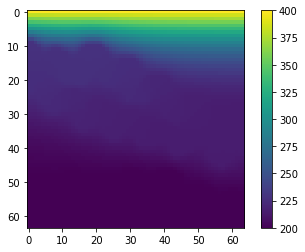

In [27]:
plt.imshow(pres_test_64[55, 0])  # 30 days  bar
plt.colorbar()

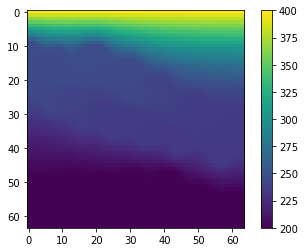

In [28]:
plt.imshow(pres_test_64[55, 1]) # 60 days
plt.colorbar()

#### 3.2 Load and run pre-trained operator for evaluation

In [25]:
bound_pres_large = 400
bound_pres_small = 200
start_V_cycle_num = 1
total_V_cycle_num = 60
compl_levels_singleV = [64, 32, 16, 8, 4]
multiV_levels = [[8, 4] for i in range(11)] + [[8], [8]] + \
                [[16, 8, 4] for i in range(11)] + [[16], [16]] + \
                [[32, 16, 8, 4] for i in range(11)] + [[32], [32]] + \
                [[64, 32, 16, 8, 4] for i in range(11)] + [[64], [64]] + \
                [[64] for i in range(total_V_cycle_num - 52)]

compl_train_epochs_singleV = [80, 80, 80, 80, 80]
model_save_dir = '/scratch/users/suihong/MutiGrid_2D/TrainedModels/2D_SingleTime/'
batch_size = 256
learning_rate = 1e-4


In [26]:
# Load saved trained models     
def load_models(model_dir, V_cycle, levels):
    # e.g., V_cycle = 1
    # e.g., levels = [64, 32, 16, 8]
    # e.g., model_dir = '/scratch/users/suihong/MutiGrid_2D/TrainedModels/BoundPres_360_260/'  
    model_save_dir = model_dir + 'Vcycle' + str(V_cycle) + '/'
    CNN_models_load = []
    for i in range(len(levels)):
        level = levels[i]
        model_name = 'CNNmodel_' + str(level)
        CNN_models_load.append(tf.keras.models.load_model(model_save_dir + model_name, compile = False))
    return CNN_models_load

In [28]:
eva_V_cycle_num = 60
# predict pressure maps using NN pipelines for test permeability maps
test_perms = [perm_test_64, perm_test_32, perm_test_16,perm_test_8, perm_test_4]

pipls_list = build_Vcycle_pipls(eva_V_cycle_num, multiV_levels, model_save_dir)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


19
20
21
22
23
24
25
26
27
28
29
30
31


32
33
34
35
36
37
38
39
40
41
42


43
44
45
46
47
48
49
50


51
52
53
54
55
56
57
58
59
60


In [29]:
# predict with operator including different numbers of V cycles

test_perms = test_perms
test_pred_dict = {}
test_residual_dict = {}
for i in range(1, eva_V_cycle_num + 1):
    test_pred_dict['test_pred_V' + str(i)], test_residual_dict['test_residual_V' + str(i)] = \
    pred_with_Vcycle_pipls(i, pipls_list, compl_levels_singleV, multiV_levels, test_perms)


In [30]:
pres_test_64_residual = np.zeros((perm_test_64.shape[0], 1, 64, 64))  # residual of truth pressure for after 1 day
pres_test_64_residual = residual_matrix(perm_test_64, pres_test_64[:,0:1])

##### Show pressure and residual maps after different V cycles; compare them with Eclipse-produced results. Eclipse results are the second row

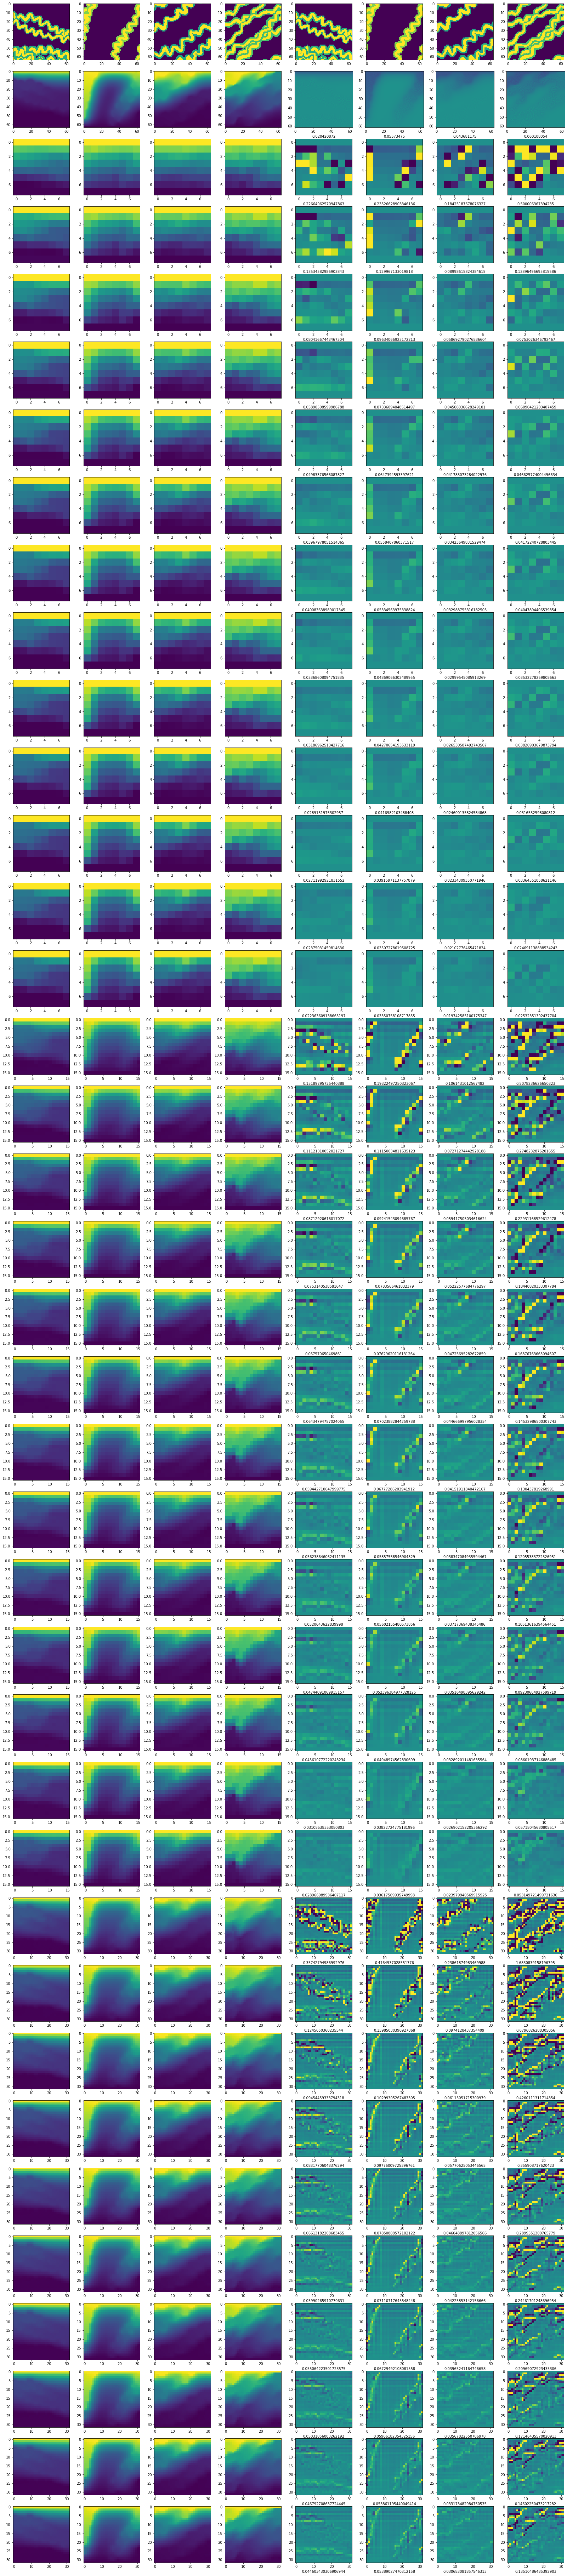

In [69]:
pixel = 64
fig, ax = plt.subplots(36 + 2, 4 * 2)
fig.set_size_inches(4 * 3.5 * 2, (36+ 2) * 3.5, forward=True)
show_index = [55, 155, 255, 355]
for i in range(4):
    ax[0, i].imshow(perm_test_64[show_index[i], 0])
    ax[0, i + 4].imshow(perm_test_64[show_index[i], 0])
    ax[1, i].imshow(pres_test_64[show_index[i], 0])
    ax[1, i + 4].imshow(pres_test_64_residual[show_index[i], 0], vmin = -0.5, vmax = 0.5)
    ax[1, i + 4].set_xlabel(np.mean(np.abs(pres_test_64_residual[show_index[i], 0])))  
    for j in range(1, 37):
        ax[j + 1, i].imshow(test_pred_dict['test_pred_V' + str(j)][show_index[i], 0])
        ax[j + 1, i+4].imshow(test_residual_dict['test_residual_V' + str(j)][show_index[i], 0], vmin = -0.5, vmax = 0.5)
        ax[j + 1, i+4].set_xlabel(np.mean(np.abs(test_residual_dict['test_residual_V' + str(j)][show_index[i], 0])))

##### Show pressure and residual maps after different V cycles; compare them with Eclipse-produced results. Eclipse results are the second row

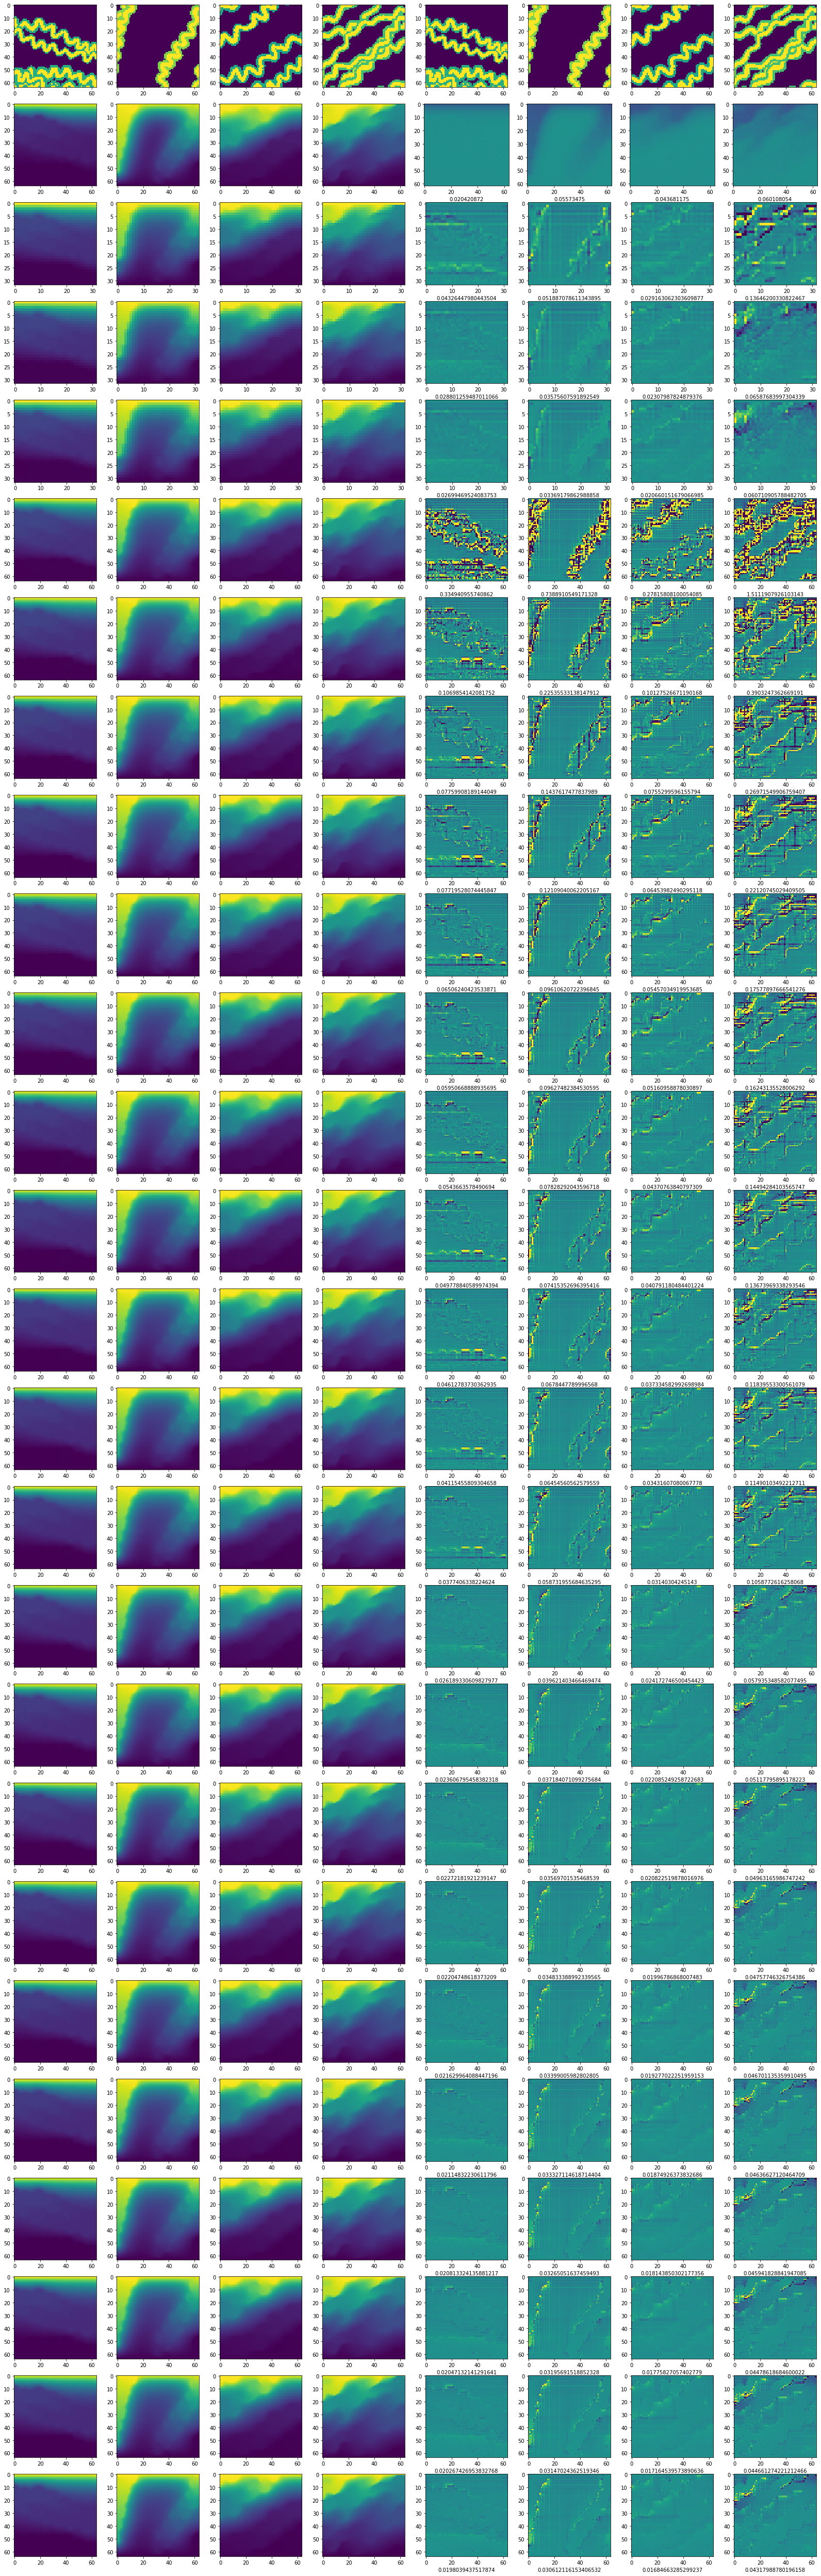

In [70]:
pixel = 64
fig, ax = plt.subplots(eva_V_cycle_num - 36 + 2, 4 * 2)   # (int(eva_V_cycle_num) + 2, 4 * 2)
fig.set_size_inches(4 * 3.5 * 2, (eva_V_cycle_num - 36+ 2) * 3.5, forward=True)
show_index = [55, 155, 255, 355]
for i in range(4):
    ax[0, i].imshow(perm_test_64[show_index[i], 0])
    ax[0, i + 4].imshow(perm_test_64[show_index[i], 0])
    ax[1, i].imshow(pres_test_64[show_index[i], 0])
    ax[1, i + 4].imshow(pres_test_64_residual[show_index[i], 0], vmin = -0.5, vmax = 0.5)
    ax[1, i + 4].set_xlabel(np.mean(np.abs(pres_test_64_residual[show_index[i], 0])))  
    for j in range(1, eva_V_cycle_num - 36 + 1):
        ax[j + 1, i].imshow(test_pred_dict['test_pred_V' + str(j + 36)][show_index[i], 0])
        ax[j + 1, i+4].imshow(test_residual_dict['test_residual_V' + str(j+ 36)][show_index[i], 0], vmin = -0.5, vmax = 0.5)
        ax[j + 1, i+4].set_xlabel(np.mean(np.abs(test_residual_dict['test_residual_V' + str(j+ 36)][show_index[i], 0])))

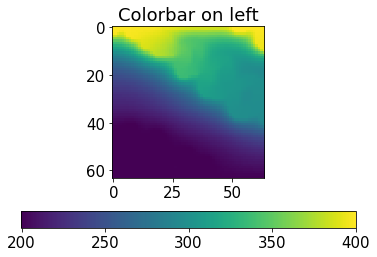

In [57]:
#create subplot
fig = plt.figure()
ax = fig.add_subplot(111)
axp = ax.imshow(test_pred_dict['test_pred_V' + str(j)][show_index[i], 0])
ax.set_title('Colorbar on left')
 
#adding colorbar and its position
cb = plt.colorbar(axp ,ax = [ax], location = 'bottom')
plt.show()

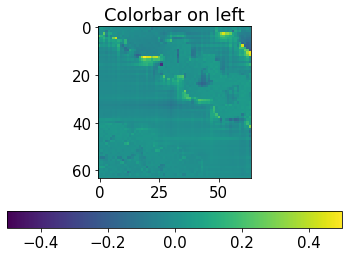

In [58]:
#create subplot
fig = plt.figure()
ax = fig.add_subplot(111)
axp = ax.imshow(test_residual_dict['test_residual_V' + str(j)][show_index[i], 0], vmin = -0.5, vmax = 0.5)
ax.set_title('Colorbar on left')
 
#adding colorbar and its position
cb = plt.colorbar(axp ,ax = [ax], location = 'bottom')
plt.show()

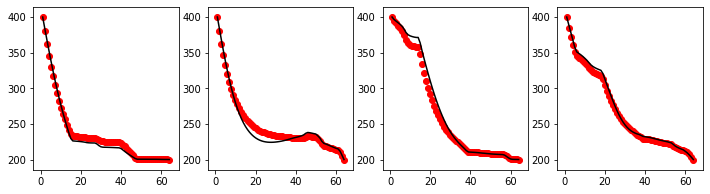

In [71]:
fig, ax = plt.subplots(1, 4)
fig.set_size_inches(12, 3, forward=True)
show_index = [55, 155, 255, 355]
for i in range(4):
    ax[i].plot(np.arange(1, 65), pres_test_64[show_index[i], 0, :, 32], c = 'k')
    ax[i].scatter(np.arange(1, 65), test_pred_dict['test_pred_V' + str(int(eva_V_cycle_num))][show_index[i], 0, :, 32], c = 'r')
    

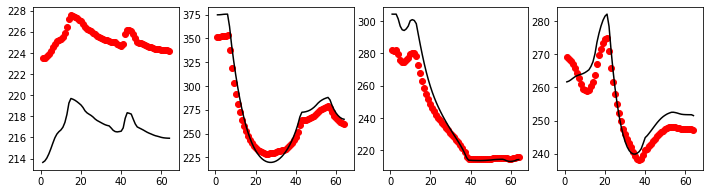

In [72]:
fig, ax = plt.subplots(1, 4)
fig.set_size_inches(12, 3, forward=True)
show_index = [55, 155, 255, 355]
for i in range(4):
    ax[i].plot(np.arange(1, 65), pres_test_64[show_index[i], 0, 32, :], c = 'k')
    ax[i].scatter(np.arange(1, 65), test_pred_dict['test_pred_V' + str(int(eva_V_cycle_num))][show_index[i], 0, 32,:], c = 'r')
    

In [73]:
pres_test_64.shape

(640, 4, 64, 64)

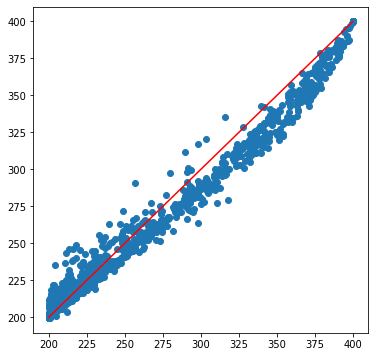

In [74]:
t = pres_test_64.shape[0] * 1 * pres_test_64.shape[2] * pres_test_64.shape[3]
rand_sq = np.random.randint(0, high=t, size=1000, dtype=int)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6, 6, forward=True)
ax.scatter(pres_test_64[:, 0].reshape(-1)[rand_sq], test_pred_dict['test_pred_V' + str(int(eva_V_cycle_num))].reshape(-1)[rand_sq])
ax.plot(np.arange(200, 401), np.arange(200, 401), c = 'r')

Text(0, 0.5, 'Average of absolute residual means')

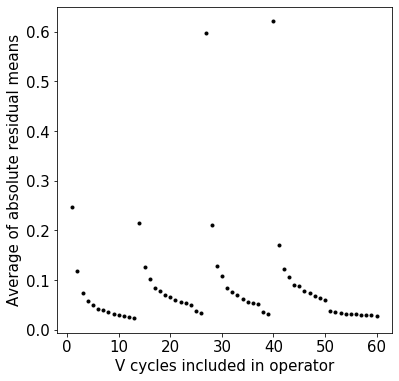

In [63]:
plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6, 6, forward=True)
for j in range(1, int(eva_V_cycle_num) + 1):
    ax.plot(j, np.mean(np.abs(test_residual_dict['test_residual_V' + str(j)])), 'k.')

ax.set_xlabel('V cycles included in operator')    
ax.set_ylabel('Average of absolute residual means')    

In [41]:
for j in range(1, int(eva_V_cycle_num) + 1):
    print(np.mean(np.abs(test_residual_dict['test_residual_V' + str(j)])))

0.2464923598989742
0.11853082271738628
0.07449512877769279
0.05748679164152577
0.04858387872261858
0.04188591617127315
0.03849059405382178
0.03510519124405818
0.031782495049614036
0.029701263355060802
0.0281687637067801
0.024704495413286766
0.023405531014457637
0.21551163114363106
0.12575692817544945
0.10142690803300906
0.08480086117368665
0.07688358107044828
0.07023220927870288
0.06571714335168481
0.060074926827003196
0.05612158835917689
0.053081143844770654
0.04974667890794495
0.03740296830150922
0.03435518354107978
0.5970607107979173
0.21158321084376314
0.12856833732937298
0.1072943332083566
0.08377449265760675
0.07505987684230486
0.07003189295537993
0.061404144731274105
0.05660264716414609
0.05373838762851137
0.05134632111343458
0.03500917284615693
0.03233504907230674
0.6209172375661669
0.1695884537323413
0.12156345336265087
0.10620973557971751
0.08982266237009315
0.08748980735555237
0.07730361893108878
0.0733977800963822
0.06810675344797584
0.06385615718604967
0.05999264834487759


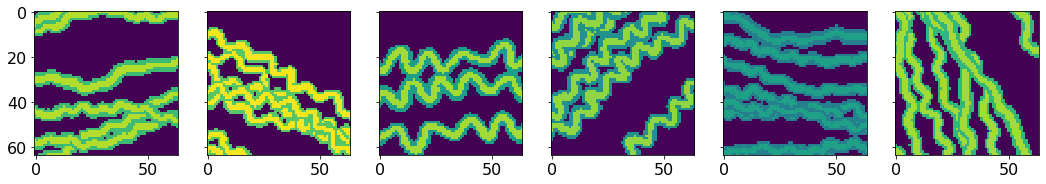

In [85]:
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(1, 6, sharey = True)   # (int(eva_V_cycle_num) + 2, 4 * 2)
fig.set_size_inches(18, 3, forward=True)
show_index = [111, 562, 12548, 6257, 25641, 9999]
for i in range(6):
    ax[i].imshow(perm_train_64[show_index[i], 0], vmax = 4000, vmin = 0)


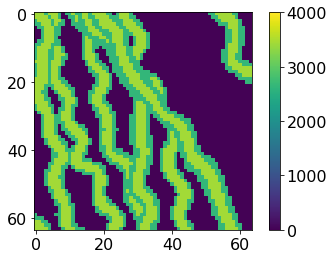

In [86]:
plt.imshow(perm_train_64[show_index[5], 0], vmax = 4000, vmin = 0)
plt.colorbar()

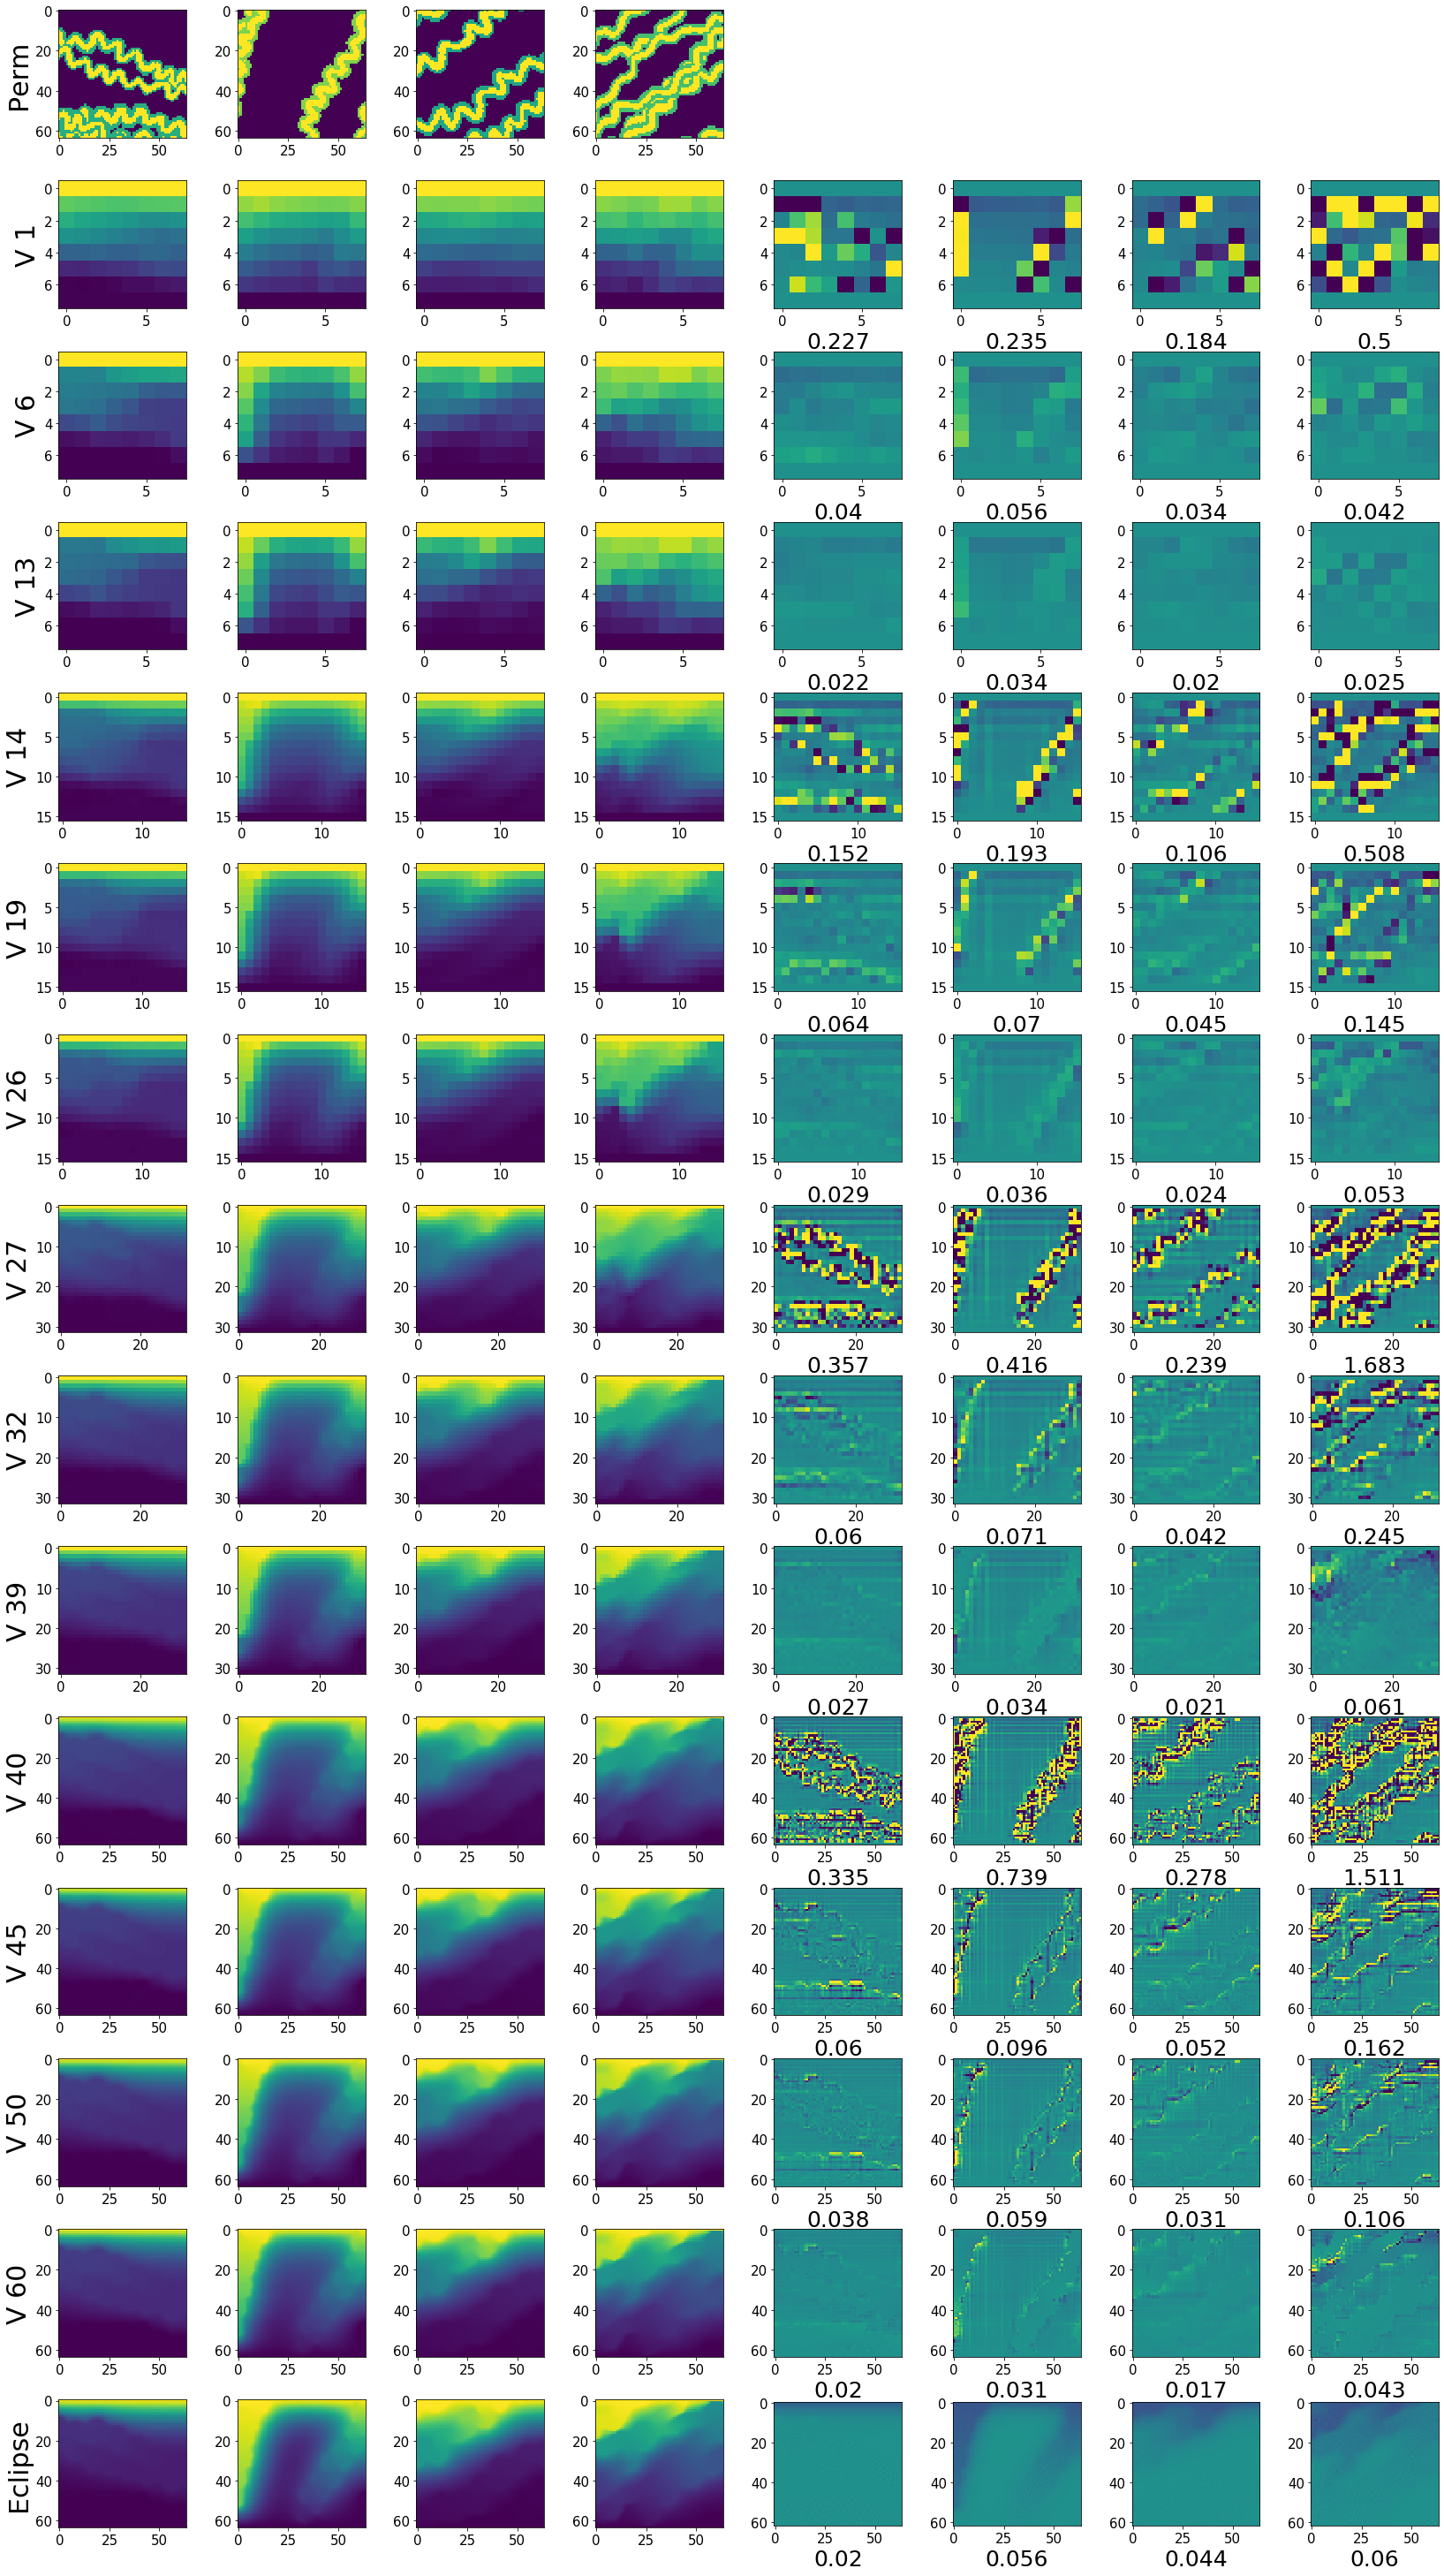

In [107]:
plt.rcParams.update({'font.size': 15})

showV_index = [1, 6, 13, 14, 19, 26, 27, 32, 39, 40, 45, 50, 60]

fig, ax = plt.subplots(13 + 2, 4 * 2)   # (int(eva_V_cycle_num) + 2, 4 * 2)
fig.set_size_inches(4 * 3.5 * 2, (13+ 2) * 3.5, forward=True)
fig.subplots_adjust(wspace=0.4, hspace=0.3)

show_index = [55, 155, 255, 355]
for i in range(4):
    ax[0, i].imshow(perm_test_64[show_index[i], 0])
    ax[0, i + 4].set_frame_on(False)
    ax[0, i + 4].tick_params(bottom=False, left=False)
    ax[0, i + 4].set(xticks=[], yticks=[])  # remove the tick lab
    ax[0, 0].set_ylabel('Perm', fontsize=30)
    for j in range(13):
        ax[j + 1, i].imshow(test_pred_dict['test_pred_V' + str(showV_index[j])][show_index[i], 0])
        ax[j + 1, i+4].imshow(test_residual_dict['test_residual_V' + str(showV_index[j])][show_index[i], 0], vmin = -0.5, vmax = 0.5)
        ax[j + 1, i+4].set_xlabel(round(np.mean(np.abs(test_residual_dict['test_residual_V' + str(showV_index[j])][show_index[i], 0])), 3), fontsize=25)    
        ax[j+1, 0].set_ylabel('V ' + str(showV_index[j]), fontsize=30)
        
    ax[14, i].imshow(pres_test_64[show_index[i], 0])
    ax[14, i + 4].imshow(pres_test_64_residual[show_index[i], 0], vmin = -0.5, vmax = 0.5)
    ax[14, i + 4].set_xlabel(round(np.mean(np.abs(pres_test_64_residual[show_index[i], 0])), 3), fontsize=25) 
    ax[14, 0].set_ylabel('Eclipse', fontsize=30)

    
    

In [44]:


test_res_64_ecl_abs_mean = np.mean(np.abs(pres_test_64_residual), axis = (1, 2, 3))


0.055406213
0.023517141


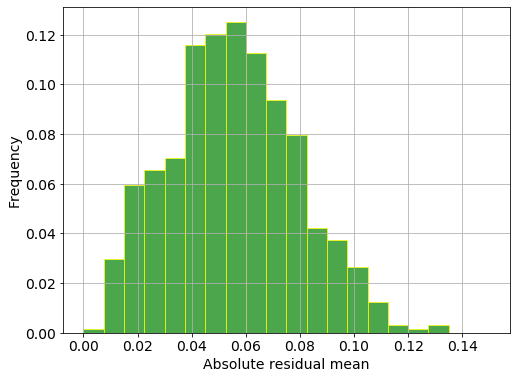

In [64]:

plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8, 6))
plt.grid(True)
plt.hist(test_res_64_ecl_abs_mean, bins = 20, ec="yellow", fc="g", alpha=0.7, weights=np.zeros_like(test_res_64_ecl_abs_mean) + 1. / len(test_res_64_ecl_abs_mean), range = (0, 0.15))
# 
plt.xlabel('Absolute residual mean')
plt.ylabel('Frequency')
# plt.title('Histogram of IQ')


print(np.mean(test_res_64_ecl_abs_mean))
print(np.std(test_res_64_ecl_abs_mean))

In [49]:
 

test_res_64_V60_abs_mean = np.mean(np.abs(test_residual_dict['test_residual_V60']), axis = (1, 2, 3))


0.027956673652672716
0.008384932643428433


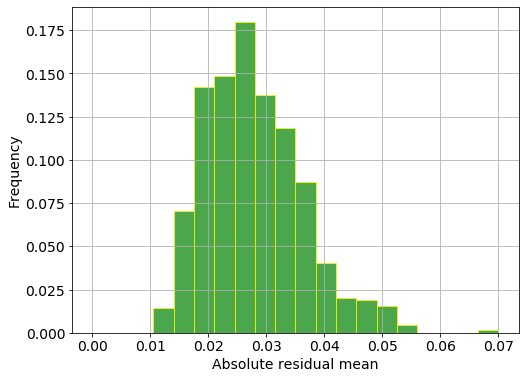

In [65]:

plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8, 6))

plt.hist(test_res_64_V60_abs_mean, bins = 20, ec="yellow", fc="g", alpha=0.7, weights=np.zeros_like(test_res_64_V60_abs_mean) + 1. / len(test_res_64_V60_abs_mean), range = (0, 0.07))
# 
plt.xlabel('Absolute residual mean')
plt.ylabel('Frequency')
# plt.title('Histogram of IQ')
plt.grid(True)

print(np.mean(test_res_64_V60_abs_mean))
print(np.std(test_res_64_V60_abs_mean))

In [32]:
mg_time_V60_st = time.time()

test_perms = test_perms
pred_with_Vcycle_pipls(60, pipls_list, compl_levels_singleV, multiV_levels, test_perms)
    
mg_time_V60_ed = time.time()
print('Seconds used: ' + str(mg_time_V60_ed - mg_time_V60_st))
print("Seconds used for each perm curve:" + str((mg_time_V60_ed - mg_time_V60_st)/640))

Seconds used: 22.58120107650757
Seconds used for each perm curve:0.03528312668204307


In [76]:
mg_time_V39_st = time.time()

test_perms = test_perms
pred_with_Vcycle_pipls(39, pipls_list, compl_levels_singleV, multiV_levels, test_perms)
    
mg_time_V39_ed = time.time()
print('Seconds used: ' + str(mg_time_V39_ed - mg_time_V39_st))
print("Seconds used for each perm curve:" + str((mg_time_V39_ed - mg_time_V39_st)/640))

Seconds used: 10.302145957946777
Seconds used for each perm curve:0.01609710305929184


In [77]:
print(0.0161/0.0289)

0.5570934256055363
